In [1]:
import csv
import math
import gzip
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import gzip
import pickle
import decimal

In [6]:
lineNames = ["SC05","A900","A975","A976", "PO88"]

scaffNames = ["scaffold_6540","scaffold_6500","scaffold_6680","scaffold_6496",
              "scaffold_6473","scaffold_6328","scaffold_6308","scaffold_6359"]

scaffSizes = [34148556,32352404,24764193,26866924,
              16943266,4453435,3356042,4525533]

scaffChrDic = {"scaffold_6540":"Chr 2", "scaffold_6500":"Chr 3","scaffold_6680":"Chr 4", "scaffold_6496":"Chr 5"}

bedFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/gimble.mainScaffs.bed"
genotypesFile = '/home/miguel/Desktop/HonoursProject/Data/forMiguel/inbredGenotypes.txt'
dataSaveFile = "/home/miguel/Desktop/HonoursProject/Data/forMiguel/scaffGenotypeDict"

In [7]:
scaffIndexDict={a:b for (a,b) in  list(zip(scaffNames,range(len(scaffNames))))}
strainIndexDict={a:b for (a,b) in  list(zip(lineNames,range(len(lineNames))))}

In [8]:
def check_genotypes(gl):
    ggl = [x.strip().split("/" or "|") for x in gl]
    ggl = [ 1 if (('.' in x) or (len(x)<2)) else (1 if x[0]==x[1] else 2) for x in ggl ]
    return(ggl)

def count_sites(arr): #this is an array of positions for a particular strain
    (unique,counts) = np.unique(arr,return_counts=True)
    zeros = 0
    ones = 0
    twos = 0
    for xl in list(zip(unique,counts)):
        if xl[0] == 0:
            zeros = xl[1]
        if xl[0] == 1:
            ones = xl[1]
        if xl[0] == 2:
            twos = xl[1]
    return([zeros,ones,twos])

def calc_diversity(winArr): # a window of sites, each has the genotypes
    countsByStrain = [count_sites(x) for x in winArr.transpose()] #transpose to get strain-wise site list
    divByStrain = [0 if (x[1]+x[2])==0 else 1.0/2*x[2]/(x[1]+x[2]) for x in countsByStrain]
    return(divByStrain)

In [9]:
with gzip.open(dataSaveFile,mode="rb") as infile:
    scaffGenotypeDict = pickle.load(infile)

In [13]:
def get_hetTracks(scaffoldGenotypes):
    # here, this is passed as the entry of the dictionary imported above
    # already uses threshold value to return 0s and 1s rather than chunk-wise diversity values.
    testchr = scaffoldGenotypes
    
    chunkSize = 50000
    windowWidth = 3 #as a number of chunks per window
    stride = 1  #should probably keep as 1
    threshold = 0.002
    
    
    numChunks = int(len(testchr)/chunkSize)
    chunks = np.array_split(testchr,numChunks)
    chunkSizeTrue = len(chunks[1])
    
    midPoints = [ i*chunkSizeTrue+ chunkSizeTrue/2 for i in range(numChunks)]
    
    divCalc = [calc_diversity(x) for x in chunks]
    divCalc = np.asarray(divCalc)
    #returns list of windows, each window a list of per-strain results. 
    #take the transpose to get each strain as a list of the windows
    allcounts = [[count_sites(y) for y in x.transpose()] for x in chunks]
    # print(allcounts[1])
    coverage = [(chunkSizeTrue-x[0])/chunkSizeTrue for x in [y[0]for y in allcounts]]
    
    divCalcByStrain = divCalc.transpose()

    windows = [] #windows in terms of left and right [l,r] indices of the underlying chunks
    for x in range(0,numChunks-(windowWidth-stride),stride):
        windows.append([x,x+windowWidth])

    res = [   [[] for x in range(numChunks)] for y in range(len(lineNames)) ]
        #each item in res will be for a different strain.  
        # for each strain, we go through the (overlapping) windows. Each window gets an average score from underlying chunks
        # each of the chunks is a list of the average values from the windows that cover it
        # the chunks at the begiining and end will have fewer scores (fewer overlapping windows)
    for strainIdx in range(len(lineNames)):    
        for [l,r] in windows: 
            #calc average diversity in this window as mean diversity in underlying chunks
            thisWinDiv = divCalcByStrain[strainIdx][l:r]
            total = sum(thisWinDiv)
            mean = total/len(thisWinDiv)
            #for each chunk in this window, append the corresponding score.We drop the last few windows 
            for x in range(l,r,1):
                res[strainIdx][x].append(mean)

    overlapingDivCalcByStrain = [[ max(x) for x in thisRes] for thisRes in res]
     #i.e. we will give any chunk the highest score from the windows which contain it
     # this makes sense for spanning data
     # we could also take the average or any other function.
    overlapingDivCalcByStrain = np.asanyarray(overlapingDivCalcByStrain)
    
    overlapingDivCalcByStrain = [[ sum(x)/float(len(x)) for x in thisRes] for thisRes in res]
    overlapingDivCalcByStrain = [[1 if (max(x)>=threshold) else 0 for x in thisRes] for thisRes in res]  ##modified to return 1 or 0 already
    thisData = np.asanyarray(overlapingDivCalcByStrain)
    
    return([midPoints,thisData])
        

In [14]:
print(plt.style.available)

['seaborn-notebook', 'dark_background', 'seaborn-pastel', 'seaborn-muted', 'seaborn', 'seaborn-bright', 'seaborn-whitegrid', 'seaborn-talk', 'fivethirtyeight', 'seaborn-colorblind', 'seaborn-paper', 'classic', 'seaborn-darkgrid', 'seaborn-dark', 'seaborn-poster', 'tableau-colorblind10', 'seaborn-white', 'fast', 'bmh', 'seaborn-ticks', 'seaborn-deep', 'seaborn-dark-palette', 'ggplot', 'grayscale', 'Solarize_Light2', '_classic_test']


<function matplotlib.pyplot.show(*args, **kw)>

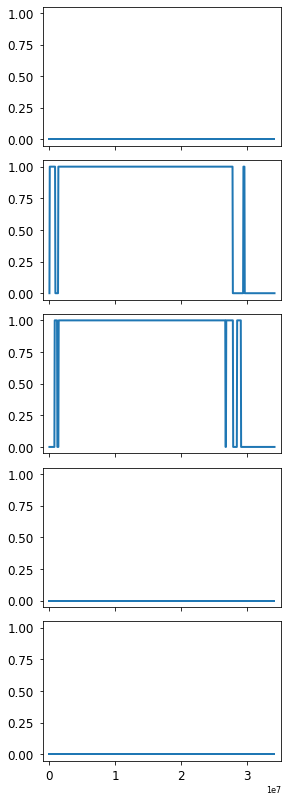

In [15]:
# added a function that takes the genotypes from the dictionary 
# it returns the midpoints and the data by strain for this chromosome. 

#for a particular chromosome...
testres1 = get_hetTracks(scaffGenotypeDict["scaffold_6540"])
midPoints,dataByStrain = testres1

# note, you should try to re-order the strains to cluster them together pairwsie...
dataByStrain = [ dataByStrain[i] for i in [0,1,4,2,3]]

#define a few (global) style choices for the figures. can change at any point.
plt.style.use("seaborn-paper")
plt.rcParams.update({'figure.autolayout': True})

#create a figure with 5 suplots arranged as 5 rows and 1 column.  They share an x scale and y scale
# we will make one for each scaffold, then copy them into inkscape and put them together
# also gives us axes. each axis in axes is one of our sub-figures. Indexed normally like list (or matrix) 
fig, axes = plt.subplots(5,1,sharex=True,sharey=True) # column for this chromosome, row for each strain

fig.set_size_inches(4,2.25*5) #adjust this to make figures diff sizes. #Here, 16x9 aspect ratio (4x2.25 for reasonable size) and 2.25 *5 because 5 rows so 5 times the height needed in the figure

#zip together the list of axes and the corresponding data, then make the plot for each
for (ax,dat) in list(zip(axes,dataByStrain)):
    
    
    ax.set_ylim(-0.05,1.05) # add a bit of space at top and bottom
    ax.set_xlim(-10**6,midPoints[-1]+10**6) # add a bit of space at left and right (before reach frame)
    
    #later, can add single y-label and x-label for the full grid. You could add them to each subplot using:
    #ax.set_xlabel("Location",fontsize=12,fontweight='bold') #add bold x-label
    #ax.set_ylabel("Heterozygous Tracts",fontsize=12,fontweight='bold') #add bold y-label
    
    ax.tick_params(axis='both',which='both',labelsize=12) #make the 
    ax.plot(midPoints,dat,linewidth=2)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

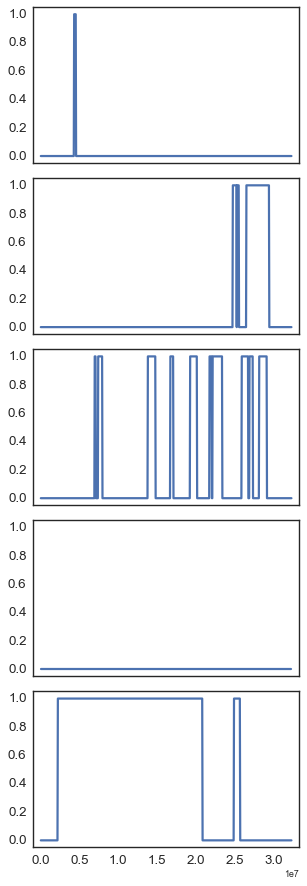

In [122]:
testres1 = get_hetTracks(scaffGenotypeDict["scaffold_6500"])
midPoints,dataByStrain = testres1

dataByStrain = [ dataByStrain[i] for i in [0,1,4,2,3]]


plt.style.use("seaborn-paper")
plt.rcParams.update({'figure.autolayout': True})


fig, axes = plt.subplots(5,1,sharex=True,sharey=True) 
fig.set_size_inches(4,2.25*5)


for (ax,dat) in list(zip(axes,dataByStrain)):
    
    
    ax.set_ylim(-0.05,1.05) 
    ax.set_xlim(-10**6,midPoints[-1]+10**6) 
    
   
    
    ax.tick_params(axis='both',which='both',labelsize=12
    ax.plot(midPoints,dat,linewidth=2)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

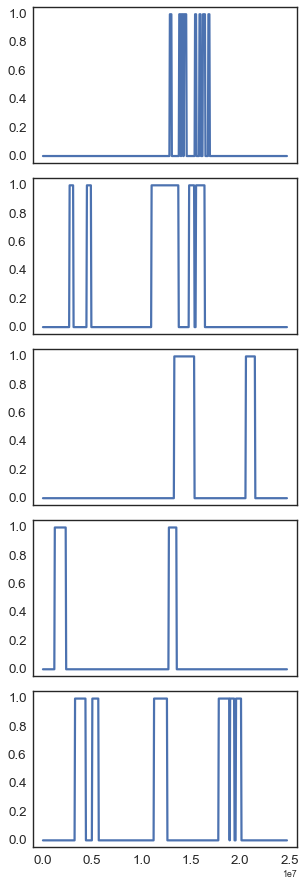

In [123]:

testres1 = get_hetTracks(scaffGenotypeDict["scaffold_6680"])
midPoints,dataByStrain = testres1

dataByStrain = [ dataByStrain[i] for i in [0,1,4,2,3]]


plt.style.use("seaborn-paper")
plt.rcParams.update({'figure.autolayout': True})


fig, axes = plt.subplots(5,1,sharex=True,sharey=True) 
fig.set_size_inches(4,2.25*5)


for (ax,dat) in list(zip(axes,dataByStrain)):
    
    
    ax.set_ylim(-0.05,1.05) 
    ax.set_xlim(-10**6,midPoints[-1]+10**6) 
    
   
    
    ax.tick_params(axis='both',which='both',labelsize=12
    ax.plot(midPoints,dat,linewidth=2)

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

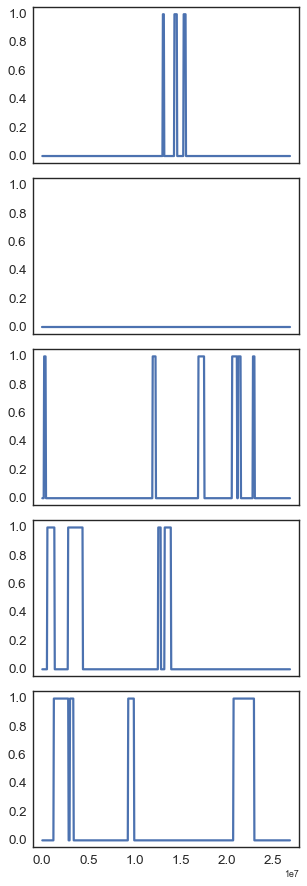

In [124]:

testres1 = get_hetTracks(scaffGenotypeDict["scaffold_6496"])
midPoints,dataByStrain = testres1

dataByStrain = [ dataByStrain[i] for i in [0,1,4,2,3]]


plt.style.use("seaborn-paper")
plt.rcParams.update({'figure.autolayout': True})


fig, axes = plt.subplots(5,1,sharex=True,sharey=True) 
fig.set_size_inches(4,2.25*5)


for (ax,dat) in list(zip(axes,dataByStrain)):
    
    
    ax.set_ylim(-0.05,1.05) 
    ax.set_xlim(-10**6,midPoints[-1]+10**6) 
    
   
    
    ax.tick_params(axis='both',which='both',labelsize=12
    ax.plot(midPoints,dat,linewidth=2)

plt.show